In [46]:
pip install mysql-connector-python

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [1]:
import mysql.connector
import pandas as pd
from pyspark.sql import SparkSession

appName="Pyspark and mysql"
master = "local"


spark = SparkSession.builder.master("local").appName("PySpark_MySQL_test").getOrCreate()

conn = mysql.connector.connect(user="root", password ="password",
                              database="BenchTest",host="localhost", port= "3306")

cursor = conn.cursor

spark.sparkContext.setLogLevel('Error')

In [2]:
query = 'SELECT * from uk_tweets_like2'

In [3]:
pdf = pd.read_sql(query, con=conn)

/tmp/ipykernel_4717/2975385224.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pdf = pd.read_sql(query, con=conn)


In [4]:
conn.close()

In [5]:
df =spark.createDataFrame(pdf)

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:331: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for column, series in pdf.iteritems():


In [6]:
df.show(5)

+---+--------------------+-------------------+--------------------+-------------+------------+---------+--------------------+
| id|            Datetime|           Tweet ID|                Text|     Username|retweetCount|likeCount|            hashtags|
+---+--------------------+-------------------+--------------------+-------------+------------+---------+--------------------+
|  0|2021-10-22 23:47:...|1451696705175490568|@UKGovScotland Th...| starrybright|           0|        1|                    |
|  1|2021-10-22 23:13:...|1451688249672536066|@VernonMackie4 @b...|IanDePendence|           3|        9|                    |
|  2|2021-10-22 22:53:...|1451683065756098568|@Ride4Truth @supe...|  GasGilligan|           0|        1|['ToryAnalytica',...|
|  3|2021-10-22 20:52:...|1451652808416145421|@CharlieHeron2 @R...|   gaolcuagam|           0|        0|                    |
|  4|2021-10-22 20:38:...|1451649270994587655|@mgoldenmsp @Crai...|     jasd1314|           0|        2|['ScottishInde

In [7]:
#dropping the unnecessary id column
df = df.drop('id')

In [8]:
df.toPandas().head(5)

,Datetime,Tweet ID,Text,Username,retweetCount,likeCount,hashtags
0,2021-10-22 23:47:20+00:00,1451696705175490568,@UKGovScotland They won’t see it unless UKGov ...,starrybright,0,1,
1,2021-10-22 23:13:44+00:00,1451688249672536066,@VernonMackie4 @bilbo815 @NoToIndy1 @Phil7521 ...,IanDePendence,3,9,
2,2021-10-22 22:53:08+00:00,1451683065756098568,@Ride4Truth @supertanskiii @irlembberlin @bpol...,GasGilligan,0,1,"['ToryAnalytica', 'HostileEnvironment']"
3,2021-10-22 20:52:54+00:00,1451652808416145421,@CharlieHeron2 @RedcliffeScott @KennyFarq Enga...,gaolcuagam,0,0,
4,2021-10-22 20:38:51+00:00,1451649270994587655,@mgoldenmsp @CraigWHoy1 Yes it is what we expe...,jasd1314,0,2,['ScottishIndependence6']


In [9]:
# check for null values
df.toPandas().isna().sum()

Datetime        0
Tweet ID        0
Text            0
Username        0
retweetCount    0
likeCount       0
hashtags        0
dtype: int64

In [12]:
df.toPandas().describe()

,retweetCount,likeCount
count,18666.000000,18666.000000
mean,1.461909,5.325190
std,14.927494,58.866758
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,2.000000
max,1317.000000,5818.000000


In [14]:
import pyspark.sql.functions as func 
count_user = df.count()

# count username
df_user = df.groupBy('Username').count()\
.withColumn('%', func.round((func.col('count')/count_user)*100, 2))\
.orderBy('count', ascending=False).show(50, False)

df_user

+---------------+-----+-----+
|Username       |count|%    |
+---------------+-----+-----+
|FuckBoris_UKGov|3445 |18.46|
|bigscrab       |258  |1.38 |
|mattyourmate   |178  |0.95 |
|gylesnamopaleen|167  |0.89 |
|bea_johanssen  |151  |0.81 |
|MrLouisB22     |144  |0.77 |
|jthomson_john  |135  |0.72 |
|IssyMil        |133  |0.71 |
|definitivegazer|132  |0.71 |
|nialloconghaile|132  |0.71 |
|IndigoFast     |115  |0.62 |
|WullieHalliday |105  |0.56 |
|SeymourStrange |96   |0.51 |
|JamieStoddart  |93   |0.5  |
|Thewiseman1234 |91   |0.49 |
|suastusa       |89   |0.48 |
|BtaD42255016   |88   |0.47 |
|AlisonHarriso16|88   |0.47 |
|johannketel    |87   |0.47 |
|White692742    |82   |0.44 |
|ConsueloMariaS |77   |0.41 |
|0drat          |75   |0.4  |
|Skellywag1     |72   |0.39 |
|WeeManWiTheFlag|71   |0.38 |
|nicsadventure  |69   |0.37 |
|Tedii69        |65   |0.35 |
|AnnonymousAm   |63   |0.34 |
|emackenzie21   |62   |0.33 |
|KSmth2000      |61   |0.33 |
|NicholNeil     |60   |0.32 |
|jimmerfae

In [16]:
from pyspark.sql import SQLContext
import seaborn as sns 
import matplotlib.pyplot as plt

df.registerTempTable('tweets')
sqlContext = SQLContext(spark)

In [17]:
df_users = sqlContext.sql('SELECT username, Count(*) AS count FROM tweets GROUP BY Username ORDER BY 2 DESC LIMIT 10').toPandas()

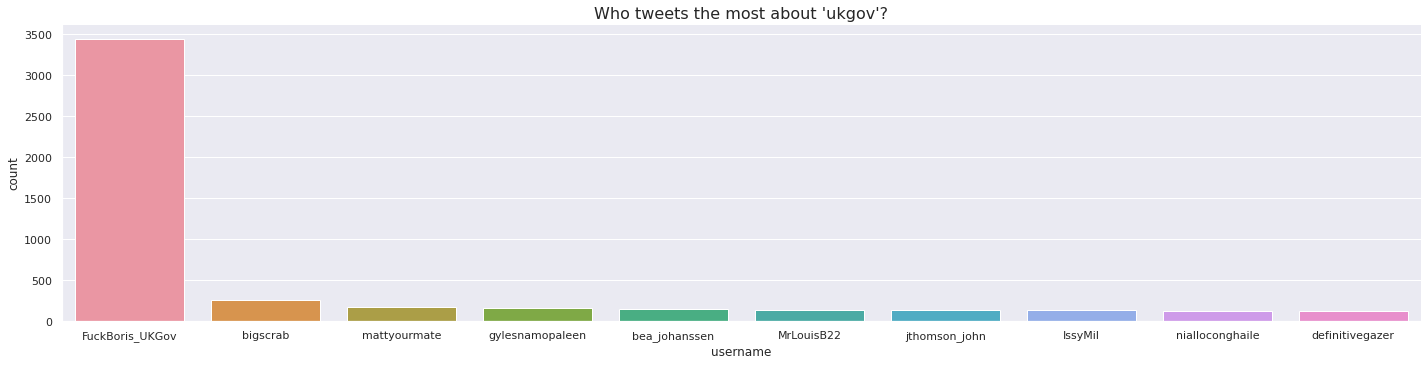

In [20]:
#plt.show()
sns.catplot(data=df_users, x='username', y='count', kind='bar', height=5, aspect=4)
#df2.head(10)
#sn
plt.title("Who tweets the most about 'ukgov'?", fontsize=16);
#sns.countplot(df2['offense'], df2['count(1)'])

sns.set();
sns.set_palette('rainbow');
plt.show();

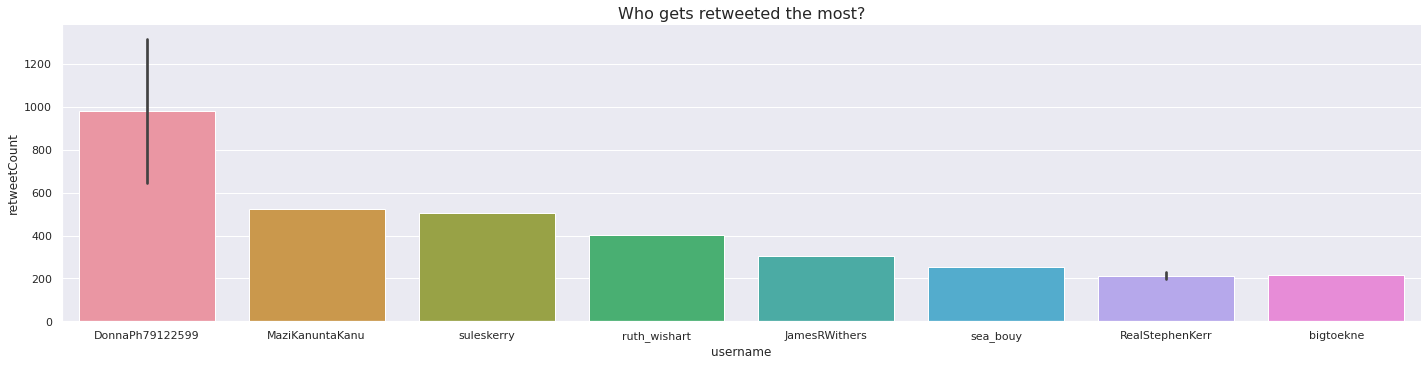

In [19]:
#query
df_retweet = sqlContext.sql('SELECT username, retweetCount FROM tweets ORDER BY 2 DESC LIMIT 10').toPandas()

#plt.show()
sns.catplot(data=df_retweet, x='username', y='retweetCount', kind='bar', height=5, aspect=4)
#df2.head(10)
#sn
plt.title("Who gets retweeted the most?", fontsize=16);
#sns.countplot(df2['offense'], df2['count(1)'])

sns.set();
sns.set_palette('rainbow');
plt.show();

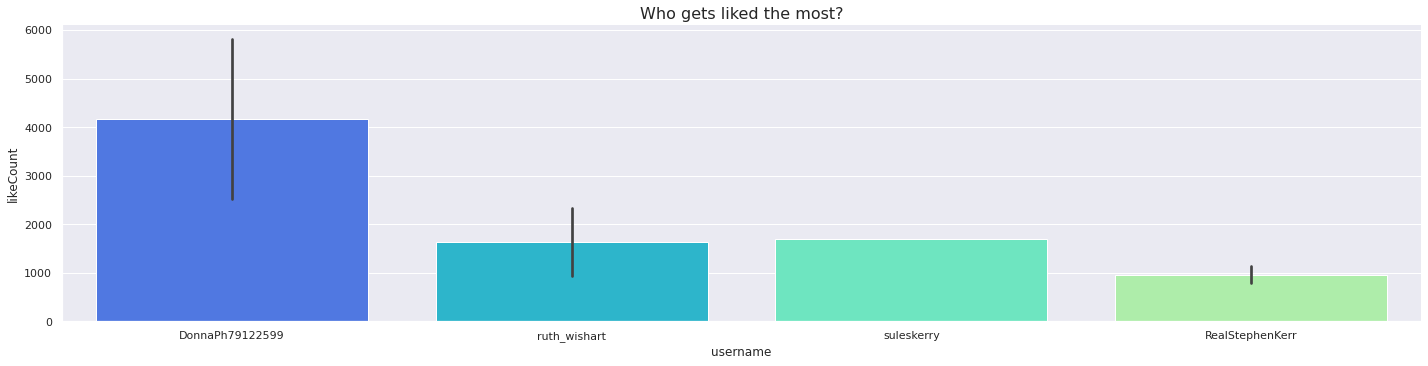

In [167]:
#query

df_like = sqlContext.sql('SELECT username, likeCount FROM tweets ORDER BY 2 DESC LIMIT 10').toPandas()

#plt.show()
sns.catplot(data=df_like, x='username', y='likeCount', kind='bar', height=5, aspect=4)
#df2.head(10)
#sn
plt.title("Who gets liked the most?", fontsize=16);
#sns.countplot(df2['offense'], df2['count(1)'])

sns.set();
sns.set_palette('rainbow');
plt.show(); 

In [168]:
import pyspark.sql.functions as func 
count_retweet = df.count()

df_retweet = df


df_retweet

DataFrame[Datetime: string, Tweet ID: string, Text: string, Username: string, retweetCount: bigint, likeCount: bigint, hashtags: string]

In [169]:
df= df.dropDuplicates()

In [170]:
df=df.toPandas()

In [172]:
import pickle 

filename='data/data.pkl'

outfile = open(filename, 'wb')

pickle.dump(df, outfile)

outfile.close()

In [173]:
infile=open(filename, 'rb')
df_new = pickle.load(infile)
infile.close()

In [175]:
pd.__version__

'1.5.0'

In [174]:
df_new.head(5)

,Datetime,Tweet ID,Text,Username,retweetCount,likeCount,hashtags
0,2021-10-22 10:08:21+00:00,1451490603766886402,Missed our recent webinar with partners Social...,AdviceGov,0,0,"['SocialValue', 'Gov', 'Procurement', 'PublicS..."
1,2021-10-26 16:29:15+00:00,1453036010149978115,@DavidPa80122564 I think the ukgov are afraid ...,gylesnamopaleen,0,1,['brexit']
2,2021-10-29 23:23:59+00:00,1454227542680948738,@TerrorismPolice The irony...#UKGov know most ...,KSmth2000,0,0,"['UKGov', 'UKGovAndTheirIllegalProxywars']"
3,2021-11-01 14:35:47+00:00,1455181783377629197,The UKGov report implies any therapy which isn...,luluskip2malu,1,1,
4,2021-11-02 18:57:34+00:00,1455610051608162312,@flodwyns @BlokeOnWheels @SandraDunn1955 The o...,jimmerfaestoney,0,0,
